# Awesome IPython Notebook Tutorial From kaggle forum
Link: https://github.com/agconti/kaggle-titanic

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm

## Data Handling

In [2]:
df = pd.read_csv("../Data Files/train.csv") 
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 73.1+ KB


In [4]:
# Remove 'ticket' and 'cabin' because of many missing values in them
df = df.drop(['Ticket','Cabin'], axis=1)

# Removing other missing values
df = df.dropna()

## Look at data graphically

d:\python34\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


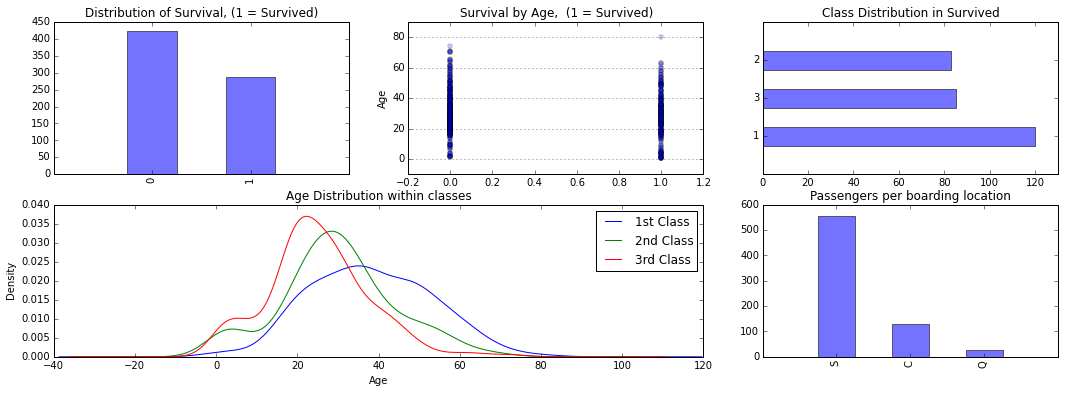

In [5]:
# specifies the parameters of our graphs
fig = plt.figure(figsize=(18,6), dpi=1600) 
alpha=alpha_scatterplot = 0.2 
alpha_bar_chart = 0.55

# lets us plot many diffrent shaped graphs together 
ax1 = plt.subplot2grid((2,3),(0,0))
# plots a bar graph of those who surived vs those who did not.               
df.Survived.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
# this nicely sets the margins in matplotlib to deal with a recent bug 1.3.1
ax1.set_xlim(-1, 2)
# puts a title on our graph
plt.title("Distribution of Survival, (1 = Survived)")    

plt.subplot2grid((2,3),(0,1))
plt.scatter(df.Survived, df.Age, alpha=alpha_scatterplot)
# sets the y axis lable
plt.ylabel("Age")
# formats the grid line style of our graphs                          
plt.grid(b=True, which='major', axis='y')  
plt.title("Survival by Age,  (1 = Survived)")

ax3 = plt.subplot2grid((2,3),(0,2))
df.Pclass[df.Survived == 1].value_counts().plot(kind="barh", alpha=alpha_bar_chart)
ax3.set_ylim(-1, len(df.Pclass.value_counts()))
ax3.set_xlim(0, 130)
plt.title("Class Distribution in Survived")

plt.subplot2grid((2,3),(1,0), colspan=2)
# plots a kernel density estimate of the subset of the 1st class passangers's age
df.Age[df.Pclass == 1].plot(kind='kde')    
df.Age[df.Pclass == 2].plot(kind='kde')
df.Age[df.Pclass == 3].plot(kind='kde')
 # plots an axis lable
plt.xlabel("Age")    
plt.title("Age Distribution within classes")
# sets our legend for our graph.
plt.legend(('1st Class', '2nd Class','3rd Class'),loc='best') 

ax5 = plt.subplot2grid((2,3),(1,2))
df.Embarked.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
ax5.set_xlim(-1, len(df.Embarked.value_counts()))
# specifies the parameters of our graphs
plt.title("Passengers per boarding location")

In [6]:
# Survived by gender
#create a plot of two subsets, male and female, of the survived variable.
#After we do that we call value_counts() so it can be easily plotted as a bar graph. 
#'barh' is just a horizontal bar graph

df_male = pd.DataFrame(df.Survived[df.Sex == 'male'].value_counts().sort_index())
df_male.columns = ['male']
df_female = pd.DataFrame(df.Survived[df.Sex == 'female'].value_counts().sort_index())
df_female.columns = ['female']
df_gender = pd.concat([df_male, df_female], axis=1)
df_gender.index.name = 'Survived'
df_gender

,male,female
Survived,,
0,360,64
1,93,195


(-1, 2)

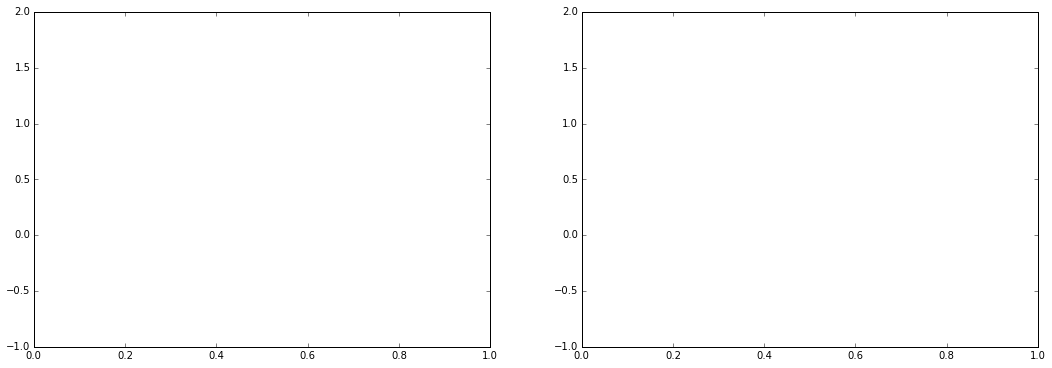

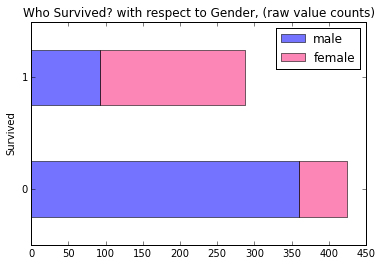

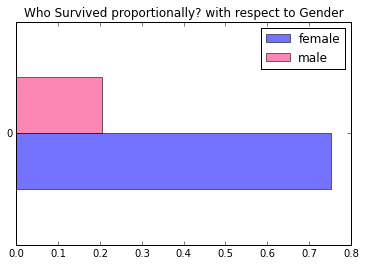

In [14]:
fig = plt.figure(figsize=(18,6))

ax1 = fig.add_subplot(121)
df_gender.plot(kind='barh', color=['b','#FA2379'], stacked=True, alpha=0.55)
plt.title("Who Survived? with respect to Gender, (raw value counts) "); plt.legend(loc='best')
ax1.set_ylim(-1, 2)

#adjust graph to display the proportions of survival by gender
ax2 = fig.add_subplot(122)
proportion = pd.DataFrame({'male': [df_gender['male'][1]/float(df_gender['male'].sum())], 
                           'female': [df_gender['female'][1]/float(df_gender['female'].sum())]})
proportion.plot(kind='barh', color=['b','#FA2379'], alpha=0.55)
plt.title("Who Survived proportionally? with respect to Gender"); plt.legend(loc='best')
ax2.set_ylim(-1, 2)

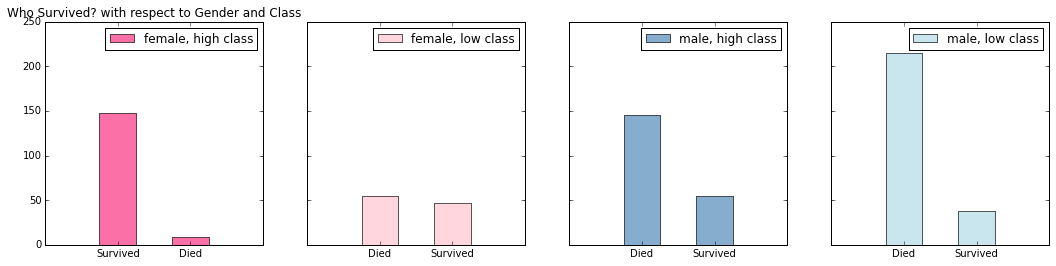

In [18]:
fig = plt.figure(figsize=(18,4), dpi=1600)
alpha_level = 0.65

# building on the previous code, here we create an additional subset with in the gender subset 
# we created for the survived variable. I know, thats a lot of subsets. After we do that we call 
# value_counts() so it it can be easily plotted as a bar graph. this is repeated for each gender 
# class pair.
ax1=fig.add_subplot(141)
female_highclass = df.Survived[df.Sex == 'female'][df.Pclass != 3].value_counts()
female_highclass.plot(kind='bar', label='female, high class', color='#FA2479', alpha=alpha_level)
ax1.set_xticklabels(["Survived", "Died"], rotation=0)
ax1.set_xlim(-1, len(female_highclass))
plt.title("Who Survived? with respect to Gender and Class"); plt.legend(loc='best')

ax2=fig.add_subplot(142, sharey=ax1)
female_lowclass = df.Survived[df.Sex == 'female'][df.Pclass == 3].value_counts()
female_lowclass.plot(kind='bar', label='female, low class', color='pink', alpha=alpha_level)
ax2.set_xticklabels(["Died","Survived"], rotation=0)
ax2.set_xlim(-1, len(female_lowclass))
plt.legend(loc='best')

ax3=fig.add_subplot(143, sharey=ax1)
male_lowclass = df.Survived[df.Sex == 'male'][df.Pclass != 3].value_counts()
male_lowclass.plot(kind='bar', label='male, high class',color='steelblue', alpha=alpha_level)
ax3.set_xticklabels(["Died","Survived"], rotation=0)
ax3.set_xlim(-1, len(male_lowclass))
plt.legend(loc='best')

ax4=fig.add_subplot(144, sharey=ax1)
male_highclass = df.Survived[df.Sex == 'male'][df.Pclass == 3].value_counts()
male_highclass.plot(kind='bar', label='male, low class', alpha=alpha_level, color='lightblue')
ax4.set_xticklabels(["Died","Survived"], rotation=0)
ax4.set_xlim(-1, len(male_highclass))
plt.legend(loc='best')

## Supervised Machine Learning

In [19]:
# Logistic Regression:

# model formula
# here the ~ sign is an = sign, and the features of our dataset
# are written as a formula to predict survived. The C() lets our 
# regression know that those variables are categorical.
# Ref: http://patsy.readthedocs.org/en/latest/formulas.html
formula = 'Survived ~ C(Pclass) + C(Sex) + Age + SibSp  + C(Embarked)' 
# create a results dictionary to hold our regression results for easy analysis later        
results = {} 

In [20]:
# create a regression friendly dataframe using patsy's dmatrices function
y,x = dmatrices(formula, data=df, return_type='dataframe')

# instantiate our model
model = sm.Logit(y,x)

# fit our model to the training data
res = model.fit()

# save the result for outputing predictions later
results['Logit'] = [res, formula]
res.summary()

Optimization terminated successfully.
         Current function value: 0.444388
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      704
Method:                           MLE   Df Model:                            7
Date:                Sun, 15 May 2016   Pseudo R-squ.:                  0.3414
Time:                        00:10:39   Log-Likelihood:                -316.40
converged:                       True   LL-Null:                       -480.45
                                        LLR p-value:                 5.992e-67
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept            4.5423      0.474      9.583      0.000         3.613     5.471
C(Pclass)[T.2]      -1.2673      0.299     -4.245      0.000        -1.852    -0.682
C(Pclass)[T.3]      -2.4966      0.296     -8.422      0.000        -3.078    -1.916
C(Sex)[T.male]      -2.6239      0.218    -12.060      0.000        -3.050    -2.197
C(Embarked)[T.Q]    -0.8351      0.597     -1.398      0.162        -2.006     0.335
C(Embarked)[T.S]    -0.4254      0.271     -1.572      0.116        -0.956     0.105
Age                 -0.0436      0.008     -5.264      0.000        -0.060    -0.027
SibSp               -0.3697      0.123     -3.004      0.003        -0.611    -0.129
====================================================================================
"""

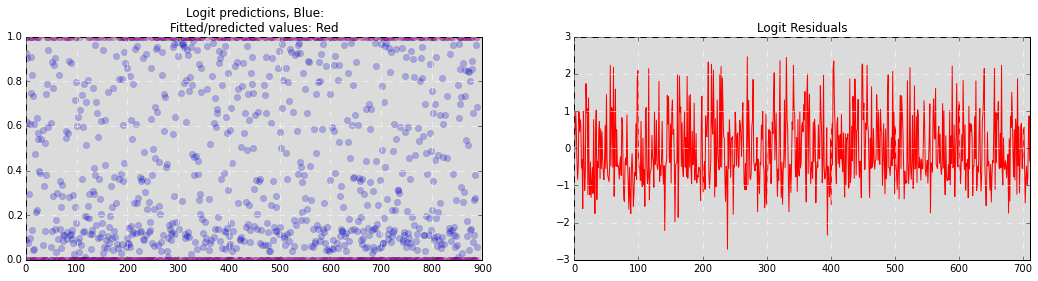

In [21]:
# Plot Predictions Vs Actual
plt.figure(figsize=(18,4));
plt.subplot(121, axisbg="#DBDBDB")
# generate predictions from our fitted model
ypred = res.predict(x)
plt.plot(x.index, ypred, 'bo', x.index, y, 'mo', alpha=.25);
plt.grid(color='white', linestyle='dashed')
plt.title('Logit predictions, Blue: \nFitted/predicted values: Red');

# Residuals
ax2 = plt.subplot(122, axisbg="#DBDBDB")
plt.plot(res.resid_dev, 'r-')
plt.grid(color='white', linestyle='dashed')
ax2.set_xlim(-1, len(res.resid_dev))
plt.title('Logit Residuals');

d:\python34\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


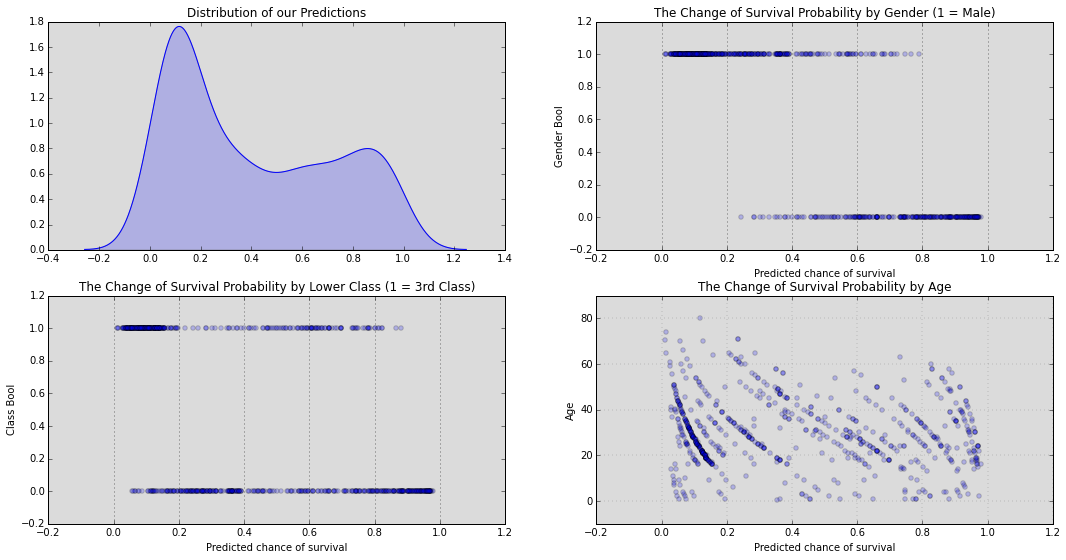

In [22]:
fig = plt.figure(figsize=(18,9), dpi=1600)
a = .2

# Below are examples of more advanced plotting. 
# It it looks strange check out the tutorial above.
fig.add_subplot(221, axisbg="#DBDBDB")
kde_res = KDEUnivariate(res.predict())
kde_res.fit()
plt.plot(kde_res.support,kde_res.density)
plt.fill_between(kde_res.support,kde_res.density, alpha=a)
plt.title("Distribution of our Predictions")

fig.add_subplot(222, axisbg="#DBDBDB")
plt.scatter(res.predict(),x['C(Sex)[T.male]'] , alpha=a)
plt.grid(b=True, which='major', axis='x')
plt.xlabel("Predicted chance of survival")
plt.ylabel("Gender Bool")
plt.title("The Change of Survival Probability by Gender (1 = Male)")

fig.add_subplot(223, axisbg="#DBDBDB")
plt.scatter(res.predict(),x['C(Pclass)[T.3]'] , alpha=a)
plt.xlabel("Predicted chance of survival")
plt.ylabel("Class Bool")
plt.grid(b=True, which='major', axis='x')
plt.title("The Change of Survival Probability by Lower Class (1 = 3rd Class)")

fig.add_subplot(224, axisbg="#DBDBDB")
plt.scatter(res.predict(),x.Age , alpha=a)
plt.grid(True, linewidth=0.15)
plt.title("The Change of Survival Probability by Age")
plt.xlabel("Predicted chance of survival")
plt.ylabel("Age")